In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import meitner
import warnings

import matplotlib.pyplot as plt

from vamas import Vamas

In [2]:
file = 'sh_all.vms'

In [3]:
data0 = meitner.Xps.from_vamas(path=file, region_id=6, break_point='search',
                                    break_point_search_interval=[447,450])
data1 = meitner.Xps.from_vamas(path=file, region_id=14, break_point='search',
                                    break_point_search_interval=[447,450])
xps_list = [data0,data1]

Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV

Found break point at 448.5 eV.
Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV

Found break point at 448.79999999999995 eV.


be goes in decreasing order!

In [22]:
fit = meitner.Fit(xps_list, n_peaks=8, first_peak_index=0, fit=False)

In [23]:
fit.peak_ids

{'d0': [0, 1, 2, 3, 4, 5, 6, 7], 'd1': [0, 1, 2, 3, 4, 5, 6, 7]}

In [58]:
# be_guess = [443.5,0,445.25,0,445.5,0,456,456.5]
# amplitude_guess = [0.4, 0, 0.3, 0, 0.3, 0, 0.02, 0.005]
be_guess = [443.5,445.25,445.5,456,456.5]
amplitude_guess = [0.4, 0.3, 0.3, 0.02, 0.005]
gamma_guess = 0.72225361

for i in range(0,6,2):
    fit.constrain_doublet(ratio='d', peak_ids=[i+1,i], splitting=7.54)

peak_ids = [i for i in range(0,6,2)] + [i for i in range(6,8,1)]
print(peak_ids)

fit.guess_multi_component(param_id='center', value=be_guess, peak_ids=peak_ids)
fit.guess_multi_component(param_id='gamma', value=gamma_guess, peak_ids=peak_ids)
fit.guess_multi_component(param_id='gamma', value=0, peak_ids=[6,7], vary=False)
fit.guess_multi_component(param_id='amplitude', value=amplitude_guess, peak_ids=peak_ids)

fit.constrain_all_gaussian_width()

for i in range(6,8,1):
    for dk in fit.dict_keys:
        fit.guess_component_parameter(param_id='sigma', value=0.5, prefix='{}_p{}'.format(dk, i), vary=True)

[0, 2, 4, 6, 7]


In [55]:
# be_guess = [443.5,445.25,445.5,456,456.5]
# amplitude_guess = [0.4, 0.3, 0.3, 0.02, 0.005]
# gamma_guess = 0.72225361
# for i in range(0,6,2):
#     fit.constrain_doublet(ratio='d', peak_ids=[i+1,i], splitting=7.54)
#     for dk in fit.dict_keys:
#         fit.guess_component_parameter(value=be_guess[int(i/2)], prefix='{}_p{}'.format(dk, i))
#         fit.guess_component_parameter(param_id='gamma', value=gamma_guess, prefix='{}_p{}'.format(dk, i))
#         fit.guess_component_parameter(param_id='amplitude', value=amplitude_guess[int(i/2)], prefix='{}_p{}'.format(dk, i))
        
# fit.constrain_all_gaussian_width()
        
# for i in range(6,8,1):
#     for dk in fit.dict_keys:
#         fit.guess_component_parameter(value=be_guess[i-3], prefix='{}_p{}'.format(dk, i))
#         fit.guess_component_parameter(param_id='gamma', value=0, prefix='{}_p{}'.format(dk, i), vary=False)
#         fit.guess_component_parameter(param_id='sigma', value=0.5, prefix='{}_p{}'.format(dk, i), vary=True)
#         fit.guess_component_parameter(param_id='amplitude', value=amplitude_guess[i-3], prefix='{}_p{}'.format(dk, i))

In [59]:
fit.fit()

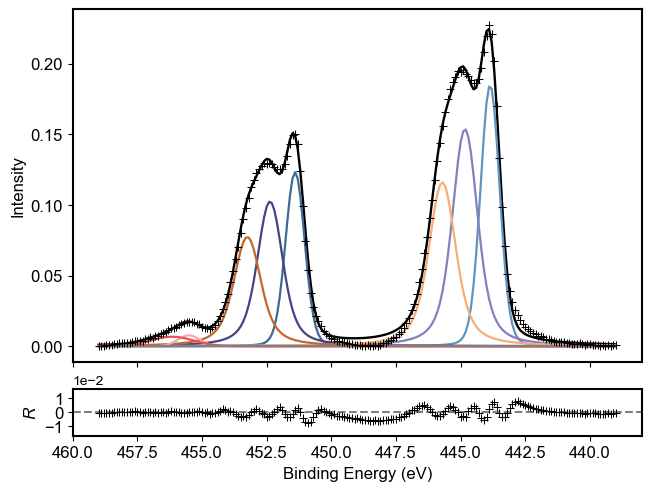

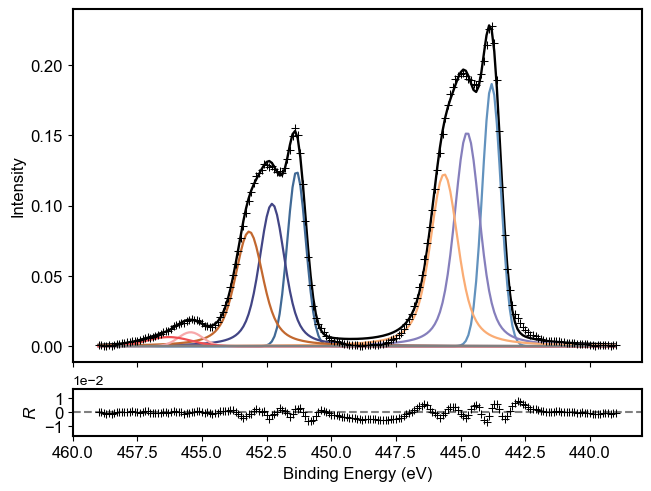

In [60]:
fit.plot_separate(display_bg=True, subtract_bg=True, envelope_zorder='bottom')

In [61]:
fit.result.params

name,value,initial value,min,max,vary,expression
d0_p0_center,443.861338,443.5,0.00000000,inf,True,
d0_p0_amplitude,0.18032453,0.4,0.00000000,inf,True,
d0_p0_sigma,0.40914719,0.5,0.00000000,inf,True,
d0_p0_gamma,0.05097862,0.72225361,0.00000000,inf,True,
d0_p0_fwhm,0.87085941,1.9558055047973095,-inf,inf,False,"calculate_voigt_fwhm(d0_p0_sigma,d0_p0_gamma)"
d0_p1_center,451.401338,451.04,-inf,inf,False,d0_p1_p0_center_spacing + d0_p0_center
d0_p1_amplitude,0.12021636,0.26666666666666666,-inf,inf,False,d0_p1_p0_amplitude_ratio * d0_p0_amplitude
d0_p1_sigma,0.40914719,0.5,-inf,inf,False,d0_p0_sigma
d0_p1_gamma,0.05097862,0.72225361,-inf,inf,False,d0_p1_p0_gamma_spacing + d0_p0_gamma
d0_p1_fwhm,0.87085941,1.9558055047973095,-inf,inf,False,"calculate_voigt_fwhm(d0_p1_sigma,d0_p1_gamma)"


In [14]:
file1 = 'au3-0001.pxt.vms'
xps1 = meitner.Xps.from_vamas(path=file1, region_id=1, shift=1)

Found 2 blocks.

Excitation energy:
655.0 eV


In [15]:
expr_constraints = {'d0_p0_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p1_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p0_center': {'value': 84, 'min': 80, 'max': 92},
                    'd0_p1_center': {'value': 88, 'min': 80, 'max': 92},
                    'd0_p0_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p0_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5}}
# expr_constraints = {'d0_p0_center': {'value': 83, 'min': 82, 'max': 84},
#                     'd0_p1_center': {'value': 86.5, 'min': 85, 'max': 88}}
fit1 = meitner.Fit(xps1, n_peaks=2, first_peak_index=0, fit=False, be_guess=[83,88],
                   expr_constraints=expr_constraints)

In [16]:
# fit1.constrain_parameter_to_reference(peak_ids=1, param_id='sigma')
fit1.constrain_all_gaussian_width()

In [17]:
fit1.xps

{'d0': <meitner.Xps at 0x17ff107c0>}

In [18]:
fit1.fit()

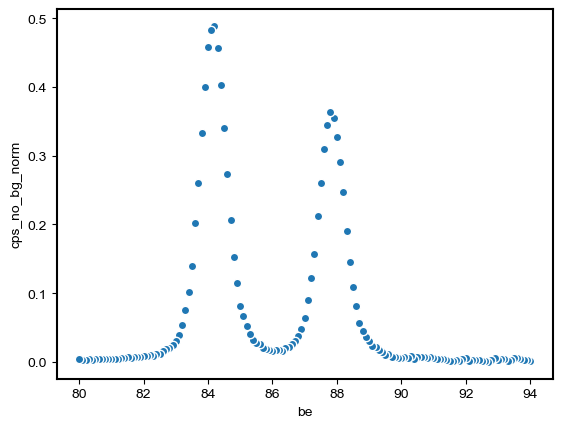

In [19]:
fit1.xps['d0'].ds.plot.scatter(x='be',y='cps_no_bg_norm')

In [20]:
fit1.xps['d0'].ds

<xarray.Dataset>
Dimensions:         (be: 141)
Coordinates:
  * be              (be) float64 94.0 93.9 93.8 93.7 ... 80.3 80.2 80.1 80.0
Data variables: (12/16)
    cps             (be) float64 6.011e+04 6.14e+04 ... 1.145e+04 1.158e+04
    ke              (be) float64 561.0 561.1 561.2 561.3 ... 574.8 574.9 575.0
    bg              (be) float64 6.292e+04 6.292e+04 ... 1.134e+04 1.134e+04
    cps_no_bg       (be) float64 -2.812e+03 -1.527e+03 ... 105.1 237.2
    bg_norm         (be) float64 0.03564 0.03564 0.03564 ... 0.009249 0.009249
    cps_norm        (be) float64 0.0342 0.03486 0.03493 ... 0.009303 0.00937
    ...              ...
    std_residual    (be) float64 0.4609 0.7521 0.7691 ... 0.3976 0.5083 0.5889
    model           (be) float64 0.03665 0.03668 0.03672 ... 0.01165 0.01155
    p0_no_bg        (be) float64 0.0003297 0.0003365 ... 0.00197 0.001875
    p0              (be) float64 0.03597 0.03598 0.03599 ... 0.01122 0.01112
    p1_no_bg        (be) float64 0.0006822 0.0007051 ... 0.0004326 0.0004216
    p1              (be) float64 0.03632 0.03635 0.03637 ... 0.009682 0.009671

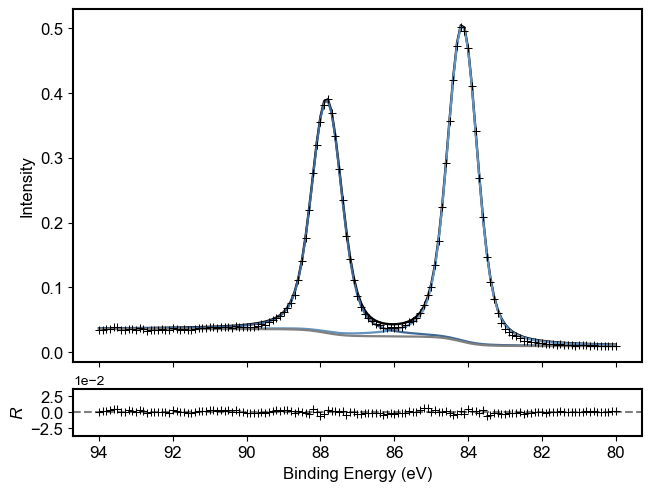

In [21]:
fit1.plot_separate(display_bg=True, subtract_bg=False, envelope_zorder='bottom')

In [22]:
if 'asdf':
    print('asdf')

asdf


In [23]:
fit1.result

In [24]:
xarr = fit.xps_concat

NameError: name 'fit' is not defined

In [ ]:
xarr.coords

Coordinates:
  * be       (be) float64 459.0 458.9 458.8 458.7 ... 439.3 439.2 439.1 439.0

In [ ]:
df = fit.xps_concat
df = df.to_dataframe(dim_order=None).reset_index()

In [ ]:
df

,be,cps,ke,bg,cps_no_bg,bg_norm,cps_norm,cps_no_bg_norm,index
0,459.0,23557.0,1027.69,23608.406501,-51.406501,0.069937,0.069798,0.006116,d0
1,458.9,23567.0,1027.79,23608.573503,-41.573503,0.069937,0.069825,0.006142,d0
2,458.8,23552.0,1027.89,23608.801676,-56.801676,0.069938,0.069784,0.006101,d0
3,458.7,23748.0,1027.99,23608.240258,139.759742,0.069936,0.070313,0.006631,d0
4,458.6,23617.0,1028.09,23608.204928,8.795072,0.069936,0.069960,0.006278,d0
...,...,...,...,...,...,...,...,...,...
397,439.4,10703.0,1047.29,10713.040375,-10.040375,0.044145,0.044109,0.005407,d1
398,439.3,10795.0,1047.39,10712.714741,82.285259,0.044144,0.044441,0.005740,d1
399,439.2,10641.0,1047.49,10712.999671,-71.999671,0.044145,0.043885,0.005183,d1
400,439.1,10692.0,1047.59,10713.083105,-21.083105,0.044145,0.044069,0.005367,d1


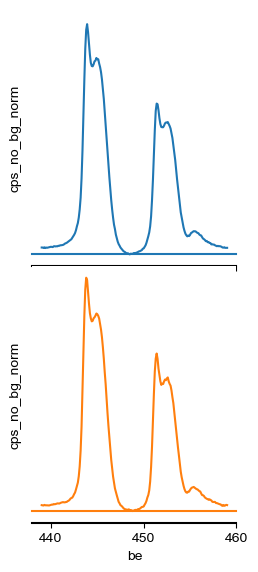

In [ ]:
g = sns.FacetGrid(df, row='index', hue='index')
g.map(plt.plot, 'be', 'cps_no_bg_norm')
g.map(plt.axhline, y=0, lw=1.5, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=False, left=True)

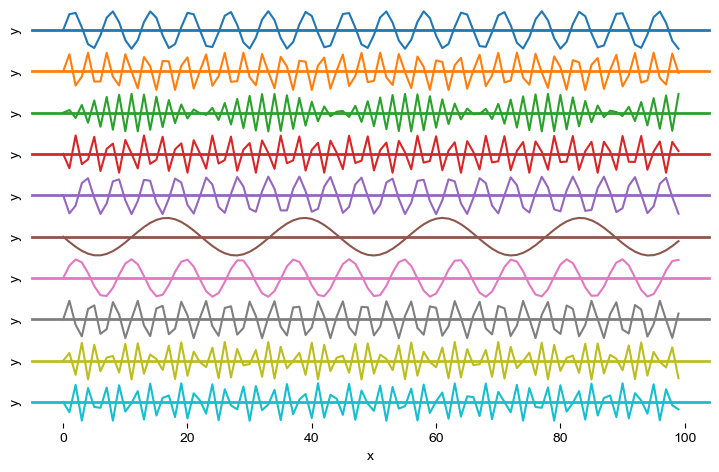

In [ ]:
segments = 10
points_per_segment = 100

#your data preparation will vary
x = np.tile(np.arange(points_per_segment), segments)
z = np.floor(np.arange(points_per_segment * segments)/points_per_segment)
y = np.sin(x * (1 + z))
        
    
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

pal = sns.color_palette()
g = sns.FacetGrid(df, row="z", hue="z", aspect=15, height=.5, palette=pal)
g.map(plt.plot, 'x', 'y')
g.map(plt.axhline, y=0, lw=2, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

In [ ]:
df['z']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    9.0
996    9.0
997    9.0
998    9.0
999    9.0
Name: z, Length: 1000, dtype: float64

<AxesSubplot:xlabel='x'>

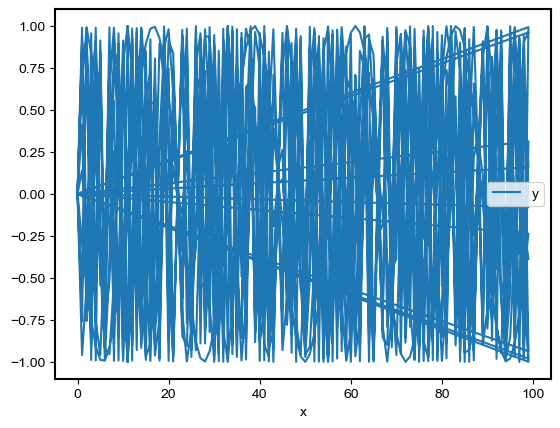

In [ ]:
df.plot(x='x',y='y')